In [2]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.2 MB/s eta 0:00:00


In [3]:
from random import choices
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator
import networkx as nx

# Step 1: Install and verify required library
try:
    import pgmpy
    print("pgmpy installed successfully!")
except ImportError:
    print("pgmpy is not installed. Install using 'pip install pgmpy'.")
    raise

pgmpy installed successfully!


In [4]:
# Step 2: Define the Bayesian Network
bn_model = BayesianNetwork([
    ('Weather', 'Traffic'),
    ('Traffic', 'Punctuality')
])

print("Bayesian Network initialized:", bn_model.edges())

Bayesian Network initialized: [('Weather', 'Traffic'), ('Traffic', 'Punctuality')]


In [5]:
# Step 3: Define CPDs
cpd_weather = TabularCPD(variable='Weather', variable_card=2, values=[[0.7], [0.3]],
                         state_names={'Weather': ['Sunny', 'Rainy']})
cpd_traffic = TabularCPD(variable='Traffic', variable_card=2, values=[[0.75, 0.2], [0.25, 0.8]],
                         evidence=['Weather'], evidence_card=[2],
                         state_names={'Traffic': ['Light', 'Heavy'], 'Weather': ['Sunny', 'Rainy']})
cpd_punctuality = TabularCPD(variable='Punctuality', variable_card=2,
                             values=[[0.9, 0.4], [0.1, 0.6]],
                             evidence=['Traffic'], evidence_card=[2],
                             state_names={'Punctuality': ['On Time', 'Late'],
                                          'Traffic': ['Light', 'Heavy']})

# Add CPDs to the model
bn_model.add_cpds(cpd_weather, cpd_traffic, cpd_punctuality)
assert bn_model.check_model(), "Model validation failed!"
print("Bayesian Network is valid!")

Bayesian Network is valid!


In [6]:
# Step 4: Query the model
inference_engine = VariableElimination(bn_model)
result = inference_engine.query(variables=['Punctuality'], evidence={'Weather': 'Rainy'})

# Interpretation of query results
result_text = (
    f"Given Rainy Weather:\n"
    f"- P(On Time): {result.values[0]:.2f}\n"
    f"- P(Late): {result.values[1]:.2f}\n"
)
print(result_text)

Given Rainy Weather:
- P(On Time): 0.50
- P(Late): 0.50



In [7]:
# Step 5: Simulate Dataset
np.random.seed(42)
def simulate_data(n=1000):
    weather_choices = ['Sunny', 'Rainy']
    traffic_choices = {'Sunny': ['Light', 'Heavy'], 'Rainy': ['Light', 'Heavy']}
    punctuality_choices = {'Light': ['On Time', 'Late'], 'Heavy': ['On Time', 'Late']}

    weather_probs = [0.7, 0.3]
    traffic_probs = {'Sunny': [0.75, 0.25], 'Rainy': [0.2, 0.8]}
    punctuality_probs = {'Light': [0.9, 0.1], 'Heavy': [0.4, 0.6]}

    data = []
    for _ in range(n):
        weather = choices(weather_choices, weather_probs)[0]
        traffic = choices(traffic_choices[weather], traffic_probs[weather])[0]
        punctuality = choices(punctuality_choices[traffic], punctuality_probs[traffic])[0]
        data.append([weather, traffic, punctuality])
    return pd.DataFrame(data, columns=['Weather', 'Traffic', 'Punctuality'])

simulated_data = simulate_data()
print("Dataset preview:\n", simulated_data.head())

Dataset preview:
   Weather Traffic Punctuality
0   Rainy   Heavy        Late
1   Sunny   Light     On Time
2   Rainy   Heavy     On Time
3   Rainy   Light     On Time
4   Sunny   Heavy        Late


In [8]:
# Step 6: Parameter Learning
mle_estimator = MaximumLikelihoodEstimator(bn_model, simulated_data)
learned_cpd_traffic = mle_estimator.estimate_cpd('Traffic')
learned_cpd_punctuality = mle_estimator.estimate_cpd('Punctuality')

# Print comparisons
print("Learned CPD for Traffic:\n", learned_cpd_traffic)
print("Learned CPD for Punctuality:\n", learned_cpd_punctuality)


Learned CPD for Traffic:
 +----------------+--------------------+--------------------+
| Weather        | Weather(Rainy)     | Weather(Sunny)     |
+----------------+--------------------+--------------------+
| Traffic(Heavy) | 0.8057324840764332 | 0.2784256559766764 |
+----------------+--------------------+--------------------+
| Traffic(Light) | 0.1942675159235669 | 0.7215743440233237 |
+----------------+--------------------+--------------------+
Learned CPD for Punctuality:
 +----------------------+--------------------+---------------------+
| Traffic              | Traffic(Heavy)     | Traffic(Light)      |
+----------------------+--------------------+---------------------+
| Punctuality(Late)    | 0.6509009009009009 | 0.08273381294964029 |
+----------------------+--------------------+---------------------+
| Punctuality(On Time) | 0.3490990990990991 | 0.9172661870503597  |
+----------------------+--------------------+---------------------+


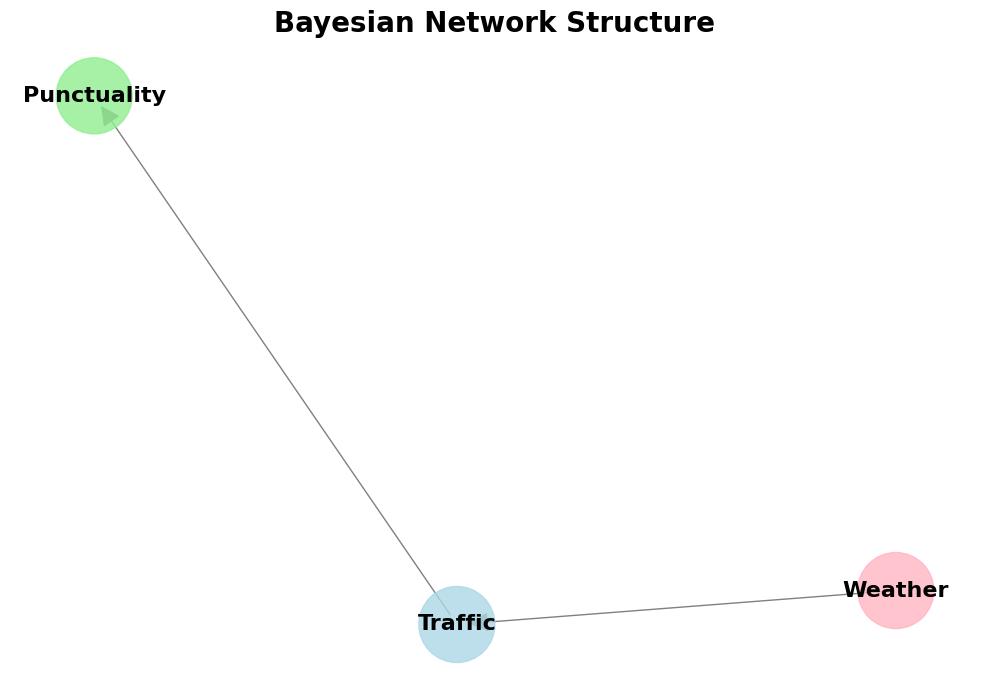

In [15]:
# Exercise 7: Enhanced Bayesian Network Visualization

# Function to visualize Bayesian Network with custom node and edge colors
def plot_bn(model, node_colors=None, edge_colors=None):
    import matplotlib.pyplot as plt
    import networkx as nx

    # Create directed graph
    G = nx.DiGraph()
    G.add_edges_from(model.edges())

    # Setup colors
    default_node_color = '#ADD8E6'
    default_edge_color = '#808080'

    node_colors = node_colors if node_colors else [default_node_color] * len(G.nodes())
    edge_colors = edge_colors if edge_colors else [default_edge_color] * len(G.edges())

    # Check for any mismatches in lengths
    if len(node_colors) < len(G.nodes()):
        node_colors.extend([default_node_color] * (len(G.nodes()) - len(node_colors)))
    if len(edge_colors) < len(G.edges()):
        edge_colors.extend([default_edge_color] * (len(G.edges()) - len(edge_colors)))

    # Set up the plot
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, arrowsize=30)

    # Add title
    plt.title("Bayesian Network Structure", fontsize=20, fontweight='bold')

    # Remove axis
    plt.axis('off')

    # Show plot
    plt.tight_layout()
    plt.show()

# Visualize the Bayesian Network
node_color_map = ['#FFB6C1', '#ADD8E6', '#90EE90']
edge_color_map = ['#808080']
plot_bn(bn_model, node_colors=node_color_map, edge_colors=edge_color_map)
